In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import plotly
import plotly.figure_factory as ff
from plotly.offline import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_columns', 300)

In [3]:
demo_features = ['X2SEX', 'X2RACE', 'X2DUALLANG', 'X2POVERTY185', 'X2SESQ5_U', 'X2CONTROL', 'X2LOCALE', 'X2REGION']


mvp_features = ['X2STU30OCC_STEM1', 'X2STUEDEXPCT', 'X2S2SSPR12', 'S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 
               'S2SSPR12', 'S2LIFES12', 'S2BIO1S12', 'S2BIO2S12', 'S2APBIOS12', 
               'S2IBIOS12', 'S2ANATOMYS12', 'S2OTHBIOS12', 'S2CHEM1S12', 'S2CHEM2S12', 'S2APCHEM12', 
               'S2IBCHEM12', 'S2EARTHS12', 'S2APENVS12', 'S2OTHENVS12', 'S2PHYSIC1S12', 
               'S2PHYSIC2S12', 'S2APPHYSIC12', 'S2IBPHYSIC12', 'S2PHYSS12', 'S2TECHS12', 'S2OTHPHYS12', 
               'S2INTGS1S12', 'S2INTGS2S12', 'S2GENS12', 'S2COMPAPP12', 'S2COMPPROG12', 
               'S2APCOMPSCI12', 'S2IBTECH12', 'S2OTHCOMP12', 'S2ENGINEER12', 'S2OTHS12', 'S2OTHS12SP', 
               'S2HISCIENCE12', 'S2APSCIENCE', 'S2IBSCIENCE', 'S2STOOKBEFORE', 'S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED', 'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 
               'S2SASSEXCL', 'S2APSCIENCE', 'S2HSPLAN', 'S2SUBMITPLAN', 'S2SCLUB', 
            'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED', 'X4RFDGMJ123', 'X4RFDGMJSTEM']

family_features = ['X2PAR1EDU', 'X2PAR1OCC_STEM1', 
            'X2PAR1RACE', 'X2PAR2EDU', 'X2PAR2OCC_STEM1', 'X2PAR2RACE', 'X2PARPATTERN', 
            'X2MOMEDU', 'X2MOMOCC_STEM1', 'X2MOMRACE', 'X2DADEDU', 'X2DADOCC_STEM1', 
            'X2DADRACE']

cols_list = demo_features + mvp_features



In [6]:
df = pd.read_csv('../data-files/HSLS/hsls_17_student_pets_sr_v1_0.csv', usecols = cols_list)
df.rename(columns = {'X4RFDGMJSTEM': 'target'}, inplace = True)

In [7]:
#drop rows with non-response to S2SLEARN (and many other features) (likely dropped from study)
df = df[df['S2SLEARN'] != -8]

#create dummy variables for races
df['ai_an'] = np.where(df['X2RACE'] == 1, 1, 0)
df['asian'] = np.where(df['X2RACE'] == 2, 1, 0)
df['black'] = np.where(df['X2RACE'] == 3, 1, 0)
df['hispanic'] = np.where((df['X2RACE'] == 4) | (df['X2RACE'] == 5), 1, 0)
df['multiple_race'] = np.where(df['X2RACE'] == 6, 1, 0)
df['nh_pi'] = np.where(df['X2RACE'] == 7, 1, 0)
df['white'] = np.where(df['X2RACE'] == 8, 1, 0)

df['female'] = np.where(df['X2SEX'] == 2, 1, 0)

In [8]:
#'X2DUALLANG', 'X2POVERTY185', 'X2SESQ5_U', 'X2CONTROL', 'X2LOCALE', 'X2REGION'

#create dummy for public/private school
df['private'] = [1 if x == 2 else 0 for x in df['X2CONTROL']]
df['public'] = [1 if x == 1 else 0 for x in df['X2CONTROL']]

In [9]:
#compile all subchoices of STEM domains into yes/no
df.X2STU30OCC_STEM1.replace({-9:0, 9:0, 4:1, 5:1, 6:1}, inplace = True)


In [10]:
classes = ['S2SSPR12', 'S2LIFES12', 'S2BIO1S12', 'S2BIO2S12', 'S2APBIOS12', 
               'S2IBIOS12', 'S2ANATOMYS12', 'S2OTHBIOS12', 'S2CHEM1S12', 'S2CHEM2S12', 'S2APCHEM12', 
               'S2IBCHEM12', 'S2EARTHS12', 'S2APENVS12', 'S2OTHENVS12', 'S2PHYSIC1S12', 
               'S2PHYSIC2S12', 'S2APPHYSIC12', 'S2IBPHYSIC12', 'S2PHYSS12', 'S2TECHS12', 'S2OTHPHYS12', 
               'S2INTGS1S12', 'S2INTGS2S12', 'S2GENS12', 'S2COMPAPP12', 'S2COMPPROG12', 
               'S2APCOMPSCI12', 'S2IBTECH12', 'S2OTHCOMP12', 'S2ENGINEER12', 'S2OTHS12', 'S2APSCIENCE', 'S2IBSCIENCE']

#impute 'no' for items that are missing or were skipped due to not taking a science class
for col in classes:
    df[col].replace({-9:0, -7:0}, inplace= True)


In [11]:
df.S2SSPR12.value_counts()

1    16192
0     4402
Name: S2SSPR12, dtype: int64

In [12]:
#impute unknown with 'no' for if participating in science activity

clubs_cols = ['S2SCLUB', 'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED']

for col in clubs_cols:
    df[col].replace({-9:0}, inplace = True)

In [13]:
df.S2HSPLAN = np.where(df['S2HSPLAN'] == 1, 1, 0)
df.S2SUBMITPLAN = np.where(df['S2SUBMITPLAN'] == 1, 1, 0)

In [14]:
#create class for underrepresented group in STEM (women, black, american indian, hispanic, pacific islander)

df['underrep'] = np.where((df['X2SEX'] == 2) |
                          (df['ai_an'] == 1) |
                          (df['black'] == 1) |
                          (df['hispanic'] == 1) |
                          (df['multiple_race'] == 1) |
                          (df['nh_pi'] == 1), 1, 0)
                         

In [15]:
#group HS science classes into broader subjects

df['bio'] = np.where((df['S2LIFES12'] == 1) |
                      (df['S2BIO1S12'] == 1) |
                      (df['S2BIO2S12'] == 1) |
                      (df['S2APBIOS12'] == 1) |
                      (df['S2IBIOS12'] == 1) |
                     (df['S2ANATOMYS12'] == 1) |
                      (df['S2OTHBIOS12'] == 1), 1, 0)
               

df['chem'] = np.where((df['S2CHEM1S12'] == 1) |
                      (df['S2CHEM2S12'] == 1) |
                      (df['S2APCHEM12'] == 1) |
                      (df['S2IBCHEM12'] == 1), 1, 0)
              

df['enviro'] = np.where((df['S2EARTHS12'] == 1) |
                        (df['S2EARTHS12'] == 1) |
                        (df['S2APENVS12'] == 1) |
                        (df['S2OTHENVS12'] == 1), 1, 0)
                        
df['physics'] = np.where((df['S2PHYSIC1S12'] == 1) |
                         (df['S2PHYSIC2S12'] == 1) |
                         (df['S2APPHYSIC12'] == 1) |
                         (df['S2IBPHYSIC12'] == 1) |
                         (df['S2PHYSS12'] == 1), 1, 0)
                         
df['engineering'] = np.where((df['S2ENGINEER12'] == 1), 1, 0)


df['compsci'] = np.where((df['S2COMPAPP12'] == 1) |
                         (df['S2COMPPROG12'] == 1) |
                         (df['S2APCOMPSCI12'] == 1) |
                         (df['S2IBTECH12'] == 1) |
                         (df['S2OTHCOMP12'] == 1), 1, 0)

df['misc_class'] = np.where((df['S2OTHPHYS12'] == 1) |
                            (df['S2INTGS1S12'] == 1) |
                            (df['S2GENS12'] == 1), 1, 0)


In [16]:
#create column for students who took science earlier in the year (but don't now)
df['took_science_2012'] = np.where((df['S2STOOKBEFORE'] == 1) |
                                   (df['bio'] == 1) |
                                   (df['chem'] == 1) |
                                   (df['enviro'] == 1) |
                                   (df['physics'] == 1) |
                                   (df['engineering'] == 1) |
                                   (df['compsci'] == 1) |
                                   (df['misc_class'] == 1), 1, 0)


In [17]:
df.took_science_2012.value_counts()

1    18051
0     2543
Name: took_science_2012, dtype: int64

In [18]:
#impute 'no' for items that are missing or were skipped due to not taking a science class

why_science = ['S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED']

for col in why_science:
    df[col].replace({-9:0, -7:0}, inplace= True)

In [19]:
#create dataframe with target variable
modeling_df = df[(df.target == 0) | (df.target == 1)]



In [20]:
likert_cols = ['S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 
                'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 
               'S2SASSEXCL']

#change likert questions to agree/disagree
for col in likert_cols:
   modeling_df[col].replace({2:1, 3:0, 4:0, -9:0, -7:0}, inplace = True)

In [21]:
modeling_df.S2SSPR12.value_counts()

1    9381
0    1593
Name: S2SSPR12, dtype: int64

In [22]:
modeling_df.groupby(by = ['target', 'underrep']).took_science_2012.value_counts(normalize = True)

target  underrep  took_science_2012
0       0         1                    0.913410
                  0                    0.086590
        1         1                    0.916964
                  0                    0.083036
1       0         1                    0.955943
                  0                    0.044057
        1         1                    0.945307
                  0                    0.054693
Name: took_science_2012, dtype: float64

In [23]:
modeling_df.underrep.value_counts(normalize = False)

1    7519
0    3455
Name: underrep, dtype: int64

In [24]:
underrep_df = modeling_df[modeling_df['underrep'] == 1]


### Initial Model - ALL

In [62]:
features = ['S2SCLUB', 'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED', 'S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP',
               'S2SASSEXCL', 'S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED', 'X2STU30OCC_STEM1', 'took_science_2012', 'bio', 'chem', 'enviro', 'physics', 'engineering', 'compsci', 'misc_class',
               'female', 'public', 'black', 'hispanic', 'asian', 'ai_an', 'multiple_race', 'nh_pi' , 'X2POVERTY185', 'underrep']


X = modeling_df.drop(columns = 'target', axis =1)
y = modeling_df['target']
X = modeling_df[features]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [40]:
features = ['S2SCLUB', 'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED', 'S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP',
               'S2SASSEXCL', 'S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED', 'X2STU30OCC_STEM1', 'took_science_2012', 'bio', 'chem', 'enviro', 'physics', 'engineering', 'compsci', 'misc_class',
           'female', 'public', 'white', 'black', 'hispanic', 'asian', 'ai_an', 'multiple_race', 'nh_pi' , 'X2POVERTY185']
                            

lr_fsm = LogisticRegression(max_iter = 10000, C = 1, random_state = 20, class_weight = 'balanced')
lr_fsm.fit(X_train, y_train)

train_pred = lr_fsm.predict(X_train)
test_pred = lr_fsm.predict(X_test)



In [28]:
coef = dict(zip(list(features), list(lr_fsm.coef_[0])))
sorted_dict1 = sorted(coef.items(), key=lambda kv: kv[1])
sorted_dict1.reverse()
sorted_dict1

[('engineering', 0.853104749244195),
 ('asian', 0.7810366266337229),
 ('X2STU30OCC_STEM1', 0.5892024529104304),
 ('compsci', 0.5623633009829604),
 ('S2SSUMMERPRG', 0.5364783521444684),
 ('S2SUSEJOB', 0.40778896223232414),
 ('S2SPERSON1', 0.3426164836707161),
 ('S2SCAREER', 0.3318294018325517),
 ('S2SPERSON2', 0.3124827040112093),
 ('physics', 0.30976708853464296),
 ('S2SCLUB', 0.2843091419838224),
 ('S2SENJOYS', 0.25652094041575363),
 ('chem', 0.21813825294027905),
 ('S2SPARREC', 0.1328488154627956),
 ('S2STCHEASY', 0.13132154878437605),
 ('S2SCOMPETE', 0.12429120125079492),
 ('S2SCHALLENGE', 0.10111060632371525),
 ('S2STEXTBOOK', 0.09620425462567227),
 ('S2SDOWELL', 0.08474941036978709),
 ('S2SUSELIFE', 0.03486828610540982),
 ('public', 0.03306374974129181),
 ('S2STESTS', 0.029403084736447618),
 ('nh_pi', 0.02778197878678847),
 ('S2SBORN', 0.027467707078547662),
 ('S2SFRIEND', 0.012143402058317015),
 ('bio', 0.010076881416170181),
 ('S2SCLGSUCC', 0.009525867912227218),
 ('S2STCHTHINK'

In [29]:
metric_dict = {}
metric_dict['LogisticRegression'] = {'train_accuracy': metrics.accuracy_score(y_train, train_pred),
                                      'test_accuracy': metrics.accuracy_score(y_test, test_pred),
                                      'train_precision':metrics.precision_score(y_train, train_pred),
                                      'test_precision':metrics.precision_score(y_test, test_pred),
                                      'train_recall':metrics.recall_score(y_train, train_pred),
                                      'test_recall':metrics.recall_score(y_test, test_pred),
                                      'train_f1':metrics.f1_score(y_train, train_pred),
                                      'test_f1':metrics.f1_score(y_test, test_pred)}

In [30]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977}}

### Initial - Underrep

In [31]:
X_ur = underrep_df.drop(columns = 'target', axis =1)
y_ur = underrep_df['target']

In [32]:
Xu_train, Xu_test, yu_train, yu_test = train_test_split(X_ur, y_ur, test_size = 0.2, random_state = 20)

In [33]:
lr_ur_fsm = LogisticRegression(max_iter = 10000, C = 10000, random_state = 20, class_weight = 'balanced')
lr_ur_fsm.fit(Xu_train[features], yu_train)

train_ur_pred = lr_ur_fsm.predict(Xu_train[features])
test_ur_pred = lr_ur_fsm.predict(Xu_test[features])


In [34]:
coef = dict(zip(list(features), list(lr_ur_fsm.coef_[0])))
sorted_dict1 = sorted(coef.items(), key=lambda kv: kv[1])
sorted_dict1.reverse()
sorted_dict1

[('asian', 0.7731438463445426),
 ('engineering', 0.7475267492037503),
 ('S2SSUMMERPRG', 0.49569656938438855),
 ('compsci', 0.47723863869786576),
 ('physics', 0.46628956227122853),
 ('X2STU30OCC_STEM1', 0.4609444252325597),
 ('S2SCLUB', 0.43691878627975295),
 ('S2SCAREER', 0.4362953184423436),
 ('S2SPERSON1', 0.34667794936629526),
 ('S2SPERSON2', 0.3364000379019939),
 ('S2SENJOYS', 0.21917536295541745),
 ('S2SUSEJOB', 0.21341719030517212),
 ('S2SUSELIFE', 0.212084899314578),
 ('chem', 0.19377985705060344),
 ('S2STEXTBOOK', 0.1818591223513519),
 ('S2SCHALLENGE', 0.180795764688041),
 ('S2SCOMPETE', 0.16796496411475834),
 ('nh_pi', 0.12428696232922809),
 ('S2SDOWELL', 0.0809884502243855),
 ('public', 0.08074282862829679),
 ('S2STCHGIVEUP', 0.07721939671587445),
 ('S2SPARREC', 0.07270300056070435),
 ('S2SBORN', 0.056445975446360375),
 ('enviro', 0.04623425152052839),
 ('took_science_2012', 0.041319904060629555),
 ('S2SASSEXCL', 0.03678935863054441),
 ('S2STESTS', 0.03486405373197467),
 ('S2

In [35]:
metric_dict['URLogisticRegression'] = {'train_accuracy': metrics.accuracy_score(yu_train, train_ur_pred),
                                      'test_accuracy': metrics.accuracy_score(yu_test, test_ur_pred),
                                      'train_precision':metrics.precision_score(yu_train, train_ur_pred),
                                      'test_precision':metrics.precision_score(yu_test, test_ur_pred),
                                      'train_recall':metrics.recall_score(yu_train, train_ur_pred),
                                      'test_recall':metrics.recall_score(yu_test, test_ur_pred),
                                      'train_f1':metrics.f1_score(yu_train, train_ur_pred),
                                      'test_f1':metrics.f1_score(yu_test, test_ur_pred)}

In [36]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 'URLogisticRegression': {'train_accuracy': 0.7014131338320865,
  'test_accuracy': 0.6808510638297872,
  'train_precision': 0.3424473330345137,
  'test_precision': 0.29853479853479853,
  'train_recall': 0.6989935956084172,
  'test_recall': 0.6269230769230769,
  'train_f1': 0.4596871239470518,
  'test_f1': 0.4044665012406947}}

### Female

In [557]:
female_df = modeling_df[modeling_df['female'] == 1]

X_or = female_df.drop(columns = 'target', axis =1)
y_or = female_df['target']

Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_or, y_or, test_size = 0.2, random_state = 20)


In [558]:
lr_or_fsm = LogisticRegression(max_iter = 10000, C = 10000, random_state = 20, class_weight = 'balanced')
lr_or_fsm.fit(Xo_train[features], yo_train)

train_or_pred = lr_or_fsm.predict(Xo_train[features])
test_or_pred = lr_or_fsm.predict(Xo_test[features])


In [559]:
coef = dict(zip(list(features), list(lr_or_fsm.coef_[0])))
sorted_dict1 = sorted(coef.items(), key=lambda kv: kv[1])
sorted_dict1.reverse()
sorted_dict1

[('engineering', 1.3198989684693165),
 ('physics', 0.7624641810840213),
 ('asian', 0.6516009531041191),
 ('S2SCLUB', 0.49654599348959166),
 ('S2SCAREER', 0.4941153426209873),
 ('compsci', 0.4619933883548328),
 ('S2SPERSON1', 0.44132750566958695),
 ('S2SSUMMERPRG', 0.4124002920894985),
 ('S2SENJOYS', 0.3484541759084331),
 ('X2STU30OCC_STEM1', 0.33720426664091685),
 ('chem', 0.3057343648880145),
 ('S2SPERSON2', 0.3049990107155956),
 ('S2STEXTBOOK', 0.2979408823918289),
 ('S2STCHGIVEUP', 0.23574104728207435),
 ('S2SCOMPETE', 0.18469173315784676),
 ('S2SDOWELL', 0.1771702826558686),
 ('S2SUSEJOB', 0.15814210033628212),
 ('S2SFAMREC', 0.15304155633455457),
 ('S2SPARREC', 0.10476055651318456),
 ('S2STCHEASY', 0.09002275789203983),
 ('enviro', 0.08880323469627034),
 ('S2STESTS', 0.0665355172381984),
 ('bio', 0.06383563144385024),
 ('public', 0.05742866936238398),
 ('S2SCHALLENGE', 0.04523592845399141),
 ('S2SUSELIFE', 0.0446145229339601),
 ('S2SGROUP', 0.025709859816214674),
 ('S2SCLGSUCC', 0

In [70]:
metric_dict['ORLogisticRegression'] = {'train_accuracy': metrics.accuracy_score(yo_train, train_or_pred),
                                      'test_accuracy': metrics.accuracy_score(yo_test, test_or_pred),
                                      'train_precision':metrics.precision_score(yo_train, train_or_pred),
                                      'test_precision':metrics.precision_score(yo_test, test_or_pred),
                                      'train_recall':metrics.recall_score(yo_train, train_or_pred),
                                      'test_recall':metrics.recall_score(yo_test, test_or_pred),
                                      'train_f1':metrics.f1_score(yo_train, train_or_pred),
                                      'test_f1':metrics.f1_score(yo_test, test_or_pred)}

In [71]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.666704636063333,
  'test_accuracy': 0.6701594533029612,
  'train_precision': 0.3795262728015246,
  'test_precision': 0.38218714768883877,
  'train_recall': 0.6829985301322881,
  'test_recall': 0.658252427184466,
  'train_f1': 0.487924396219811,
  'test_f1': 0.48359486447931527},
 'URLogisticRegression': {'train_accuracy': 0.6729842061512884,
  'test_accuracy': 0.6555851063829787,
  'train_precision': 0.31356655290102387,
  'test_precision': 0.28061224489795916,
  'train_recall': 0.6724611161939615,
  'test_recall': 0.6346153846153846,
  'train_f1': 0.42769857433808556,
  'test_f1': 0.3891509433962264},
 'ORLogisticRegression': {'train_accuracy': 0.6877713458755427,
  'test_accuracy': 0.6816208393632417,
  'train_precision': 0.546408393866021,
  'test_precision': 0.5084745762711864,
  'train_recall': 0.6922290388548057,
  'test_recall': 0.6666666666666666,
  'train_f1': 0.6107352277852954,
  'test_f1': 0.576923076923077}}

## Decision Tree - Initial

In [279]:
dtc_all = DecisionTreeClassifier(random_state = 20)

param_dict={'max_depth': range(1,10),
            'criterion': ['gini', 'entropy'],
            'splitter': ['random', 'best'],
            'max_features': ['auto', 'sqrt', 'log2']}

grid_tree=GridSearchCV(dtc_all, 
                       param_dict, 
                       cv=10, 
                       scoring='f1', 
                       verbose=1, 
                       n_jobs=-1)

In [280]:
grid_tree.fit(X_train[features],y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   25.7s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=20),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['random', 'best']},
             scoring='f1', verbose=1)

In [281]:

dtc_importance = grid_tree.best_estimator_.feature_importances_
feature_importance = dict(zip(features, dtc_importance))
sorted_dict = sorted(feature_importance.items(), key=lambda kv: kv[1])
sorted_dict.reverse()
sorted_dict

[('female', 0.1554887922883592),
 ('S2SPERSON1', 0.14177925030271188),
 ('S2SENJOYS', 0.0917635897302439),
 ('asian', 0.07183058987962251),
 ('X2STU30OCC_STEM1', 0.06984361450521487),
 ('S2SSUMMERPRG', 0.036749993665495105),
 ('S2SPERSON2', 0.033879854994902044),
 ('compsci', 0.019622837597257095),
 ('S2SBORN', 0.01852457767028244),
 ('S2SCLUB', 0.018413611978510498),
 ('S2SCAREER', 0.017325348911192216),
 ('bio', 0.015782430859809893),
 ('S2SASSIGNED', 0.01434200450966142),
 ('S2SCLGSUCC', 0.01406617579715689),
 ('physics', 0.013003096979625357),
 ('S2STCHTHINK', 0.012045695300897146),
 ('S2SCHALLENGE', 0.011770484046527141),
 ('S2STCHRREC', 0.01126131318711076),
 ('S2SHSREQ', 0.011260088767690187),
 ('S2STCHEASY', 0.010867654177187278),
 ('S2SSKILLS', 0.01085927001310943),
 ('S2SPARREC', 0.010660173623360605),
 ('chem', 0.010275593151273205),
 ('S2SCOMPETE', 0.010119045843901718),
 ('S2STCHGIVEUP', 0.009456532312119051),
 ('private', 0.009439594965031052),
 ('S2SUSECLG', 0.0094192114

In [282]:

y_pred_dtc_test = grid_tree.best_estimator_.predict(X_test[features])
y_pred_dtc_train = grid_tree.best_estimator_.predict(X_train[features])

In [283]:
metric_dict['DecisionTree'] = {'train_accuracy': metrics.accuracy_score(y_train, y_pred_dtc_train),
                                  'test_accuracy': metrics.accuracy_score(y_test, y_pred_dtc_test),
                                  'train_precision':metrics.precision_score(y_train, y_pred_dtc_train),
                                  'test_precision':metrics.precision_score(y_test, y_pred_dtc_test),
                                  'train_recall':metrics.recall_score(y_train, y_pred_dtc_train),
                                  'test_recall':metrics.recall_score(y_test, y_pred_dtc_test),
                                  'train_f1':metrics.f1_score(y_train, y_pred_dtc_train),
                                  'test_f1':metrics.f1_score(y_test, y_pred_dtc_test)}


In [284]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41867908059354086,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.705046545810877,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5253742241694048,
  'test_f1': 0.5123595505617977},
 'DecisionTree': {'train_accuracy': 0.806697801571933,
  'test_accuracy': 0.7767653758542141,
  'train_precision': 0.6733870967741935,
  'test_precision': 0.5581395348837209,
  'train_recall': 0.3272905438510534,
  'test_recall': 0.23300970873786409,
  'train_f1': 0.4404879657105176,
  'test_f1': 0.3287671232876712}}

## Grid Search LogREG

In [64]:
clf = LogisticRegression()

param_grid = {
    
    'max_iter': [100, 250, 500, 1000, 5000, 10000],
    'C': [0.001, 0.01, 1, 10, 100]
}

gs_LR = GridSearchCV(clf, param_grid, cv=5, scoring = 'f1', n_jobs = -1, verbose = 2)
gs_LR.fit(X_train, y_train)

gs_LR.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   14.2s finished


{'C': 10, 'max_iter': 100}

In [59]:
lr_gs = LogisticRegression(max_iter = 100, C = 26, random_state = 20, class_weight = 'balanced')
lr_gs.fit(X_train, y_train)

gs_train_pred = lr_gs.predict(X_train)
gs_test_pred = lr_gs.predict(X_test)

In [646]:
coef_gs = dict(zip(list(features), list(lr_gs.coef_[0])))
sorted_dict = sorted(coef_gs.items(), key=lambda kv: kv[1])
sorted_dict.reverse()
coef_df = pd.DataFrame(data = sorted_dict, columns = ['feature', 'coefficient_value'])

from math import e
coef_df['abs_value'] = abs(coef_df['coefficient_value'])
coef_df['log_odd'] = e**coef_df['coefficient_value']
coef_df.sort_values(by = 'abs_value', ascending = False, inplace = True)
coef_df['neg_odd'] = 1/coef_df['log_odd']
coef_df['likelihood'] = np.where(coef_df['log_odd'] > coef_df['neg_odd'], coef_df['log_odd'], coef_df['neg_odd'])
top_ten = coef_df[:10]
top_ten

,feature,coefficient_value,abs_value,log_odd,neg_odd,likelihood
56,female,-1.049105,1.049105,0.350251,2.855094,2.855094
0,engineering,0.879298,0.879298,2.409208,0.415074,2.409208
1,asian,0.701161,0.701161,2.016092,0.496009,2.016092
2,X2STU30OCC_STEM1,0.590256,0.590256,1.804449,0.554186,1.804449
3,compsci,0.567603,0.567603,1.764033,0.566883,1.764033
4,S2SSUMMERPRG,0.543501,0.543501,1.722025,0.580712,1.722025
55,black,-0.496604,0.496604,0.608594,1.643132,1.643132
5,S2SUSEJOB,0.410681,0.410681,1.507844,0.663199,1.507844
54,misc_class,-0.362298,0.362298,0.696075,1.436626,1.436626
6,S2SPERSON1,0.342660,0.342660,1.408690,0.709880,1.408690


In [60]:

metric_dict['GS26_LogisticRegression'] = {'train_accuracy': metrics.accuracy_score(y_train, gs_train_pred),
                                      'test_accuracy': metrics.accuracy_score(y_test, gs_test_pred),
                                      'train_precision':metrics.precision_score(y_train, gs_train_pred),
                                      'test_precision':metrics.precision_score(y_test, gs_test_pred),
                                      'train_recall':metrics.recall_score(y_train, gs_train_pred),
                                      'test_recall':metrics.recall_score(y_test, gs_test_pred),
                                      'train_f1':metrics.f1_score(y_train, gs_train_pred),
                                      'test_f1':metrics.f1_score(y_test, gs_test_pred)}

In [61]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 'URLogisticRegression': {'train_accuracy': 0.7014131338320865,
  'test_accuracy': 0.6808510638297872,
  'train_precision': 0.3424473330345137,
  'test_precision': 0.29853479853479853,
  'train_recall': 0.6989935956084172,
  'test_recall': 0.6269230769230769,
  'train_f1': 0.4596871239470518,
  'test_f1': 0.4044665012406947},
 'GS100_LogisticRegression': {'train_accuracy': 0.7039526141929605,
  'test_accuracy': 0.7043280182232347,
  'train_precision': 0.41875364006988935,
  'test_precision': 0.4180929095354523,
  'train_recall': 0.7045565899069084,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5252968036529682,
  'test_f1': 0.5131282820705176},
 'GS50_Logisti

### GridSearch UR

In [322]:
clf = LogisticRegression()

param_grid = {
    
    'max_iter': [5000, 10000, 50000, 100000],
    'C': [0.00001, 0.001, 1, 100, 10000, 1000000]
}

gs_LR_ur = GridSearchCV(clf, param_grid, cv=5)
gs_LR_ur.fit(Xu_train[features], yu_train)

gs_LR_ur.best_params_

{'C': 1, 'max_iter': 5000}

In [323]:
lr_ur_gs = LogisticRegression(max_iter = 5000, C = 1, random_state = 20, class_weight = 'balanced')
lr_ur_gs.fit(Xu_train[features], yu_train)

gstrain_ur_pred = lr_ur_gs.predict(Xu_train[features])
gstest_ur_pred = lr_ur_gs.predict(Xu_test[features])


In [324]:
coef_gs_ur = dict(zip(list(features), list(lr_ur_gs.coef_[0])))
sorted_dict2 = sorted(coef_gs_ur.items(), key=lambda kv: kv[1])
sorted_dict2.reverse()
sorted_dict2

[('asian', 0.8112040796187215),
 ('engineering', 0.704193955348958),
 ('S2SSUMMERPRG', 0.48653055850200383),
 ('compsci', 0.46904405050842013),
 ('physics', 0.463246977002566),
 ('X2STU30OCC_STEM1', 0.4599045099955091),
 ('S2SCLUB', 0.43287571791860346),
 ('S2SCAREER', 0.43259584929389194),
 ('S2SPERSON1', 0.34618477294175265),
 ('S2SPERSON2', 0.3359474520493568),
 ('S2SENJOYS', 0.21906247092169326),
 ('S2SUSEJOB', 0.2114133582139897),
 ('S2SUSELIFE', 0.21139530486503352),
 ('chem', 0.19195648967656473),
 ('S2STEXTBOOK', 0.18081133101430652),
 ('S2SCHALLENGE', 0.18048649851771298),
 ('S2SCOMPETE', 0.16970701196764676),
 ('nh_pi', 0.15593798176241208),
 ('S2SDOWELL', 0.08192550531214719),
 ('public', 0.08052686995262145),
 ('S2STCHGIVEUP', 0.07603750416146897),
 ('S2SPARREC', 0.07248354935233034),
 ('S2SBORN', 0.05572863112986972),
 ('enviro', 0.043537746472446445),
 ('took_science_2012', 0.04187690137170804),
 ('S2SASSEXCL', 0.03626163777884671),
 ('S2STESTS', 0.03530834823810092),
 ('

In [136]:
metric_dict['GS_URLogisticRegression'] = {'train_accuracy': metrics.accuracy_score(yu_train, gstrain_ur_pred),
                                      'test_accuracy': metrics.accuracy_score(yu_test, gstest_ur_pred),
                                      'train_precision':metrics.precision_score(yu_train, gstrain_ur_pred),
                                      'test_precision':metrics.precision_score(yu_test, gstest_ur_pred),
                                      'train_recall':metrics.recall_score(yu_train, gstrain_ur_pred),
                                      'test_recall':metrics.recall_score(yu_test, gstest_ur_pred),
                                      'train_f1':metrics.f1_score(yu_train, gstrain_ur_pred),
                                      'test_f1':metrics.f1_score(yu_test, gstest_ur_pred)}

In [144]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.6668185442533319,
  'test_accuracy': 0.6706150341685649,
  'train_precision': 0.37962962962962965,
  'test_precision': 0.38261851015801357,
  'train_recall': 0.6829985301322881,
  'test_recall': 0.658252427184466,
  'train_f1': 0.48800980220549633,
  'test_f1': 0.48394004282655245},
 'GS_LogisticRegression': {'train_accuracy': 0.666704636063333,
  'test_accuracy': 0.6701594533029612,
  'train_precision': 0.3795262728015246,
  'test_precision': 0.38218714768883877,
  'train_recall': 0.6829985301322881,
  'test_recall': 0.658252427184466,
  'train_f1': 0.487924396219811,
  'test_f1': 0.48359486447931527},
 'GS_URLogisticRegression': {'train_accuracy': 0.6731504571903575,
  'test_accuracy': 0.6549202127659575,
  'train_precision': 0.3138592750533049,
  'test_precision': 0.2801358234295416,
  'train_recall': 0.6733760292772186,
  'test_recall': 0.6346153846153846,
  'train_f1': 0.42815590459569514,
  'test_f1': 0.38869257950530034},
 'URLogisticR

## SELECT KBEST

In [325]:
selector = SelectKBest(f_regression, k = 20)
selector.fit(X_train[features], y_train)

SelectKBest(k=20, score_func=<function f_regression at 0x1a1661eea0>)

In [326]:
selected_columns = X_train[features].columns[selector.get_support()]

In [327]:
selected_columns

Index(['S2SCLUB', 'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SPERSON1', 'S2SPERSON2',
       'S2SUSELIFE', 'S2SUSEJOB', 'S2SENJOYING', 'S2STESTS', 'S2STEXTBOOK',
       'S2SSKILLS', 'S2STCHEASY', 'S2SENJOYS', 'S2SCHALLENGE', 'S2SCLGSUCC',
       'S2SCAREER', 'S2SDOWELL', 'X2STU30OCC_STEM1', 'female', 'asian'],
      dtype='object')

In [328]:
lr_kbest = LogisticRegression(max_iter = 5000, C = 100, class_weight = 'balanced', random_state =20)

lr_kbest.fit(X_train[selected_columns], y_train)
kbest_train_pred = lr_kbest.predict(X_train[selected_columns])
kbest_test_pred= lr_kbest.predict(X_test[selected_columns])

In [329]:
coef_kbest = dict(zip(list(selected_columns), list(lr_kbest.coef_[0])))
sorted_dict3 = sorted(coef_kbest.items(), key=lambda kv: kv[1])
sorted_dict3.reverse()
sorted_dict3

[('asian', 0.9747497403606082),
 ('X2STU30OCC_STEM1', 0.6202487198147512),
 ('S2SSUMMERPRG', 0.49888895515117476),
 ('S2SUSEJOB', 0.4019383705343208),
 ('S2SPERSON1', 0.40089181991633566),
 ('S2SPERSON2', 0.35395847687927107),
 ('S2SCAREER', 0.3163602141341),
 ('S2SCLUB', 0.2962142391455902),
 ('S2SENJOYS', 0.24054531981894503),
 ('S2SCOMPETE', 0.17332623367807973),
 ('S2SCHALLENGE', 0.12988896175376316),
 ('S2STEXTBOOK', 0.0897175262464588),
 ('S2SUSELIFE', 0.0329451917238749),
 ('S2SDOWELL', 0.014031001710456636),
 ('S2STCHEASY', 0.01060488605352337),
 ('S2SSKILLS', 0.0018908274581112357),
 ('S2STESTS', 0.000541510396906365),
 ('S2SENJOYING', -0.040280256839325464),
 ('S2SCLGSUCC', -0.12515408622126095),
 ('female', -1.0956197368617089)]

In [330]:
metric_dict['KBEST_LogisticRegression'] = {'train_accuracy': metrics.accuracy_score(y_train, kbest_train_pred),
                                      'test_accuracy': metrics.accuracy_score(y_test, kbest_test_pred),
                                      'train_precision':metrics.precision_score(y_train, kbest_train_pred),
                                      'test_precision':metrics.precision_score(y_test, kbest_test_pred),
                                      'train_recall':metrics.recall_score(y_train, kbest_train_pred),
                                      'test_recall':metrics.recall_score(y_test, kbest_test_pred),
                                      'train_f1':metrics.f1_score(y_train, kbest_train_pred),
                                      'test_f1':metrics.f1_score(y_test, kbest_test_pred)}

In [331]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 'GS_LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 'KBEST_LogisticRegression': {'train_accuracy': 0.685499487413145,
  'test_accuracy': 0.6829157175398634,
  'train_precision': 0.4007170435741864,
  'test_precision': 0.3960964408725603,
  'train_recall': 0.7119059284664381,
  'test_recall': 0.6699029126213593,
  'train_f1': 0.5127933650961709,
  'test_f1': 0.4978354978354978}}

## Viz of Results

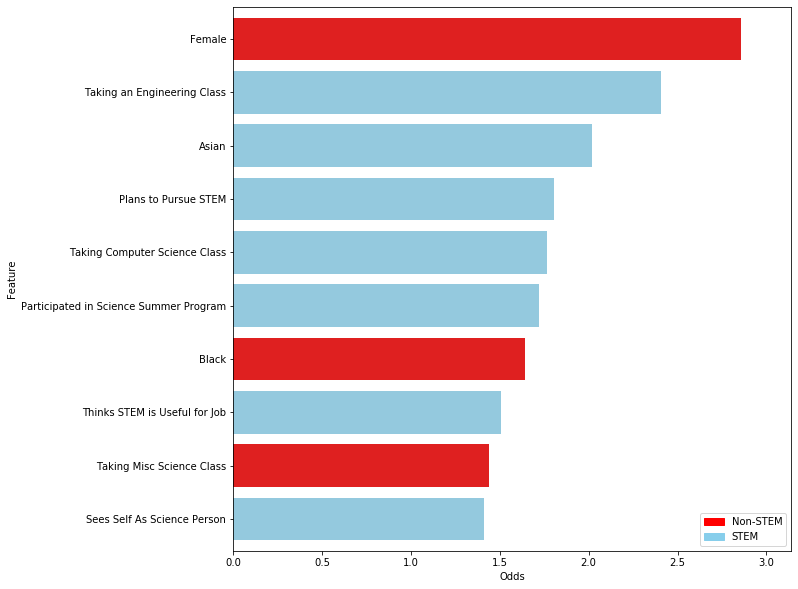

In [658]:
coef_gs = dict(zip(list(features), list(lr_gs.coef_[0])))
sorted_dict = sorted(coef_gs.items(), key=lambda kv: kv[1])
sorted_dict.reverse()
coef_df = pd.DataFrame(data = sorted_dict, columns = ['feature', 'coefficient_value'])

from math import e
coef_df['pos_odd'] = e**coef_df['coefficient_value']
coef_df['neg_odd'] = 1/coef_df['pos_odd']
coef_df['highest_odd'] = np.where(coef_df['pos_odd'] > coef_df['neg_odd'], coef_df['pos_odd'], coef_df['neg_odd'])
coef_df.sort_values(by = 'highest_odd', ascending = False, inplace = True)
top_ten = coef_df[:10]

from matplotlib.patches import Patch
plt.figure(figsize = (10,10))
clrs = ['red' if x == 'female' else 'red' if x == 'black' else 'red' if x== 'misc_class' else 'skyblue' for x in top_ten['feature']]
ax = sns.barplot(x ='highest_odd', y = 'feature', data = top_ten, palette = clrs, orient = 'horiz' )
plt.yticks(ticks = range(0,11), labels = ['Female', 'Taking an Engineering Class', 'Asian', 'Plans to Pursue STEM', 'Taking Computer Science Class', 'Participated in Science Summer Program', 'Black', 'Thinks STEM is Useful for Job', 'Taking Misc Science Class', 'Sees Self As Science Person'])
plt.margins(0.1, 0.02)
ax.set_ylabel('Feature')
ax.set_xlabel('Odds')

legend = [Patch(facecolor='red', edgecolor='red', label='Non-STEM'), Patch(facecolor='skyblue', edgecolor='skyblue', label='STEM')]
ax.legend(handles = legend)
;

plt.show()

In [659]:
top_ten

,feature,coefficient_value,pos_odd,neg_odd,highest_odd
56,female,-1.049105,0.350251,2.855094,2.855094
0,engineering,0.879298,2.409208,0.415074,2.409208
1,asian,0.701161,2.016092,0.496009,2.016092
2,X2STU30OCC_STEM1,0.590256,1.804449,0.554186,1.804449
3,compsci,0.567603,1.764033,0.566883,1.764033
4,S2SSUMMERPRG,0.543501,1.722025,0.580712,1.722025
55,black,-0.496604,0.608594,1.643132,1.643132
5,S2SUSEJOB,0.410681,1.507844,0.663199,1.507844
54,misc_class,-0.362298,0.696075,1.436626,1.436626
6,S2SPERSON1,0.342660,1.408690,0.709880,1.408690


engineering  target
0            0         8326
             1         2446
1            1          110
             0           92
Name: target, dtype: int64

## Class Imbalance Techniques

In [665]:
modeling_df.target.value_counts(normalize = True)

0    0.767086
1    0.232914
Name: target, dtype: float64

## SMOTE

In [340]:
from imblearn.over_sampling import SMOTE

In [664]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

LR_smote = LogisticRegression(C = 1, max_iter = 1000, random_state = 20)
LR_smote.fit(X_train_smote[features], y_train_smote)

smote_train_pred = LR_smote.predict(X_train_smote[features])
smote_test_pred = LR_smote.predict(X_test[features])
y_train_smote.value_counts()

1    6738
0    6738
Name: target, dtype: int64

In [360]:
coef_smote = dict(zip(list(features), list(LR_smote.coef_[0])))
sorted_dict_smote = sorted(coef_smote.items(), key=lambda kv: kv[1])
sorted_dict_smote.reverse()
sorted_dict_smote

[('took_science_2012', 0.39985531428496995),
 ('S2SUSEJOB', 0.3984085352380933),
 ('engineering', 0.37660743958284515),
 ('X2STU30OCC_STEM1', 0.3647093149452947),
 ('S2SPERSON1', 0.3511653890691704),
 ('S2SPERSON2', 0.32040936223896055),
 ('S2SDOWELL', 0.2770258165029311),
 ('S2SCAREER', 0.2643382882503973),
 ('S2SENJOYS', 0.25835140093128967),
 ('physics', 0.2563166318714798),
 ('S2SSUMMERPRG', 0.25525426889425645),
 ('chem', 0.24776128900350772),
 ('S2SEMPREC', 0.20850298590099534),
 ('S2SCLGSUCC', 0.1555142819152787),
 ('S2SCHALLENGE', 0.11915722451696496),
 ('S2STCHEASY', 0.11311685242251798),
 ('S2SUSECLG', 0.09495033129022765),
 ('compsci', 0.07253361960552857),
 ('S2SSKILLS', 0.055990413645953585),
 ('S2SCLUB', 0.025608719644789207),
 ('S2SPARREC', 0.002784060783522842),
 ('S2STEXTBOOK', -0.025646565311913297),
 ('S2STESTS', -0.035319513528605816),
 ('S2STCHTHINK', -0.046712948898992204),
 ('S2SASSEXCL', -0.05815540866646827),
 ('S2SCLGADM', -0.08836916987194854),
 ('S2STCHRREC'

8779

In [358]:
metric_dict['SMOTE_LogisticRegression'] = {'train_accuracy': metrics.accuracy_score(y_train_smote, smote_train_pred),
                                      'test_accuracy': metrics.accuracy_score(y_test, smote_test_pred),
                                      'train_precision':metrics.precision_score(y_train_smote, smote_train_pred),
                                      'test_precision':metrics.precision_score(y_test, smote_test_pred),
                                      'train_recall':metrics.recall_score(y_train_smote, smote_train_pred),
                                      'test_recall':metrics.recall_score(y_test, smote_test_pred),
                                      'train_f1':metrics.f1_score(y_train_smote, smote_train_pred),
                                      'test_f1':metrics.f1_score(y_test, smote_test_pred)
                                          }

In [359]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 'GS_LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 'KBEST_LogisticRegression': {'train_accuracy': 0.685499487413145,
  'test_accuracy': 0.6829157175398634,
  'train_precision': 0.4007170435741864,
  'test_precision': 0.3960964408725603,
  'train_recall': 0.7119059284664381,
  'test_recall': 0.6699029126213593,
  'train_f1': 0.5127933650961709,
  'test_f1': 0.4978354978354978},
 'SMOTE_Logisti

## TOMEK LINKS

In [370]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_train_tomek, y_train_tomek = tl.fit_resample(X_train, y_train)

LR_tomek = LogisticRegression(C = 100, max_iter = 150, random_state = 20)
LR_tomek.fit(X_train_tomek[features], y_train_tomek)

tomek_train_pred = LR_tomek.predict(X_train_tomek[features])
tomek_test_pred = LR_tomek.predict(X_test[features])

In [371]:
coef_tomek = dict(zip(list(features), list(LR_tomek.coef_[0])))
sorted_dict_tomek = sorted(coef_tomek.items(), key=lambda kv: kv[1])
sorted_dict_tomek.reverse()
sorted_dict_tomek

[('engineering', 0.8723915830289376),
 ('X2STU30OCC_STEM1', 0.6070018523526881),
 ('compsci', 0.5876434876493022),
 ('S2SSUMMERPRG', 0.5590555083755107),
 ('asian', 0.5060969718816933),
 ('S2SUSEJOB', 0.418376072861993),
 ('S2SPERSON1', 0.35130559276186524),
 ('S2SPERSON2', 0.31065504185851023),
 ('physics', 0.30890769056250705),
 ('S2SCAREER', 0.307807397504098),
 ('S2SCLUB', 0.26185260089999624),
 ('S2SENJOYS', 0.23296747279501007),
 ('chem', 0.21782539680398966),
 ('S2SCOMPETE', 0.1656211550914959),
 ('S2SPARREC', 0.1616894374935545),
 ('S2STCHEASY', 0.1426884958774226),
 ('S2SCHALLENGE', 0.1272864695885108),
 ('S2STEXTBOOK', 0.10337862155832893),
 ('S2SDOWELL', 0.07191957254181218),
 ('S2SCLGSUCC', 0.026537528894170357),
 ('public', 0.02043872089126251),
 ('S2SUSELIFE', 0.02041518660542837),
 ('S2SUSECLG', 0.015600259990507721),
 ('S2SFRIEND', 0.01467043528691682),
 ('S2SBORN', 0.010883709185406485),
 ('S2STCHTHINK', 0.005665358067258459),
 ('S2STESTS', 0.0017530183044296003),
 ('S

In [372]:
metric_dict['TOMEK_LogisticRegression'] = {'train_accuracy': metrics.accuracy_score(y_train_tomek, tomek_train_pred),
                                      'test_accuracy': metrics.accuracy_score(y_test, tomek_test_pred),
                                      'train_precision':metrics.precision_score(y_train_tomek, tomek_train_pred),
                                      'test_precision':metrics.precision_score(y_test, tomek_test_pred),
                                      'train_recall':metrics.recall_score(y_train_tomek, tomek_train_pred),
                                      'test_recall':metrics.recall_score(y_test, tomek_test_pred),
                                      'train_f1':metrics.f1_score(y_train_tomek, tomek_train_pred),
                                      'test_f1':metrics.f1_score(y_test, tomek_test_pred)
                                          }

In [373]:
metric_dict

{'LogisticRegression': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 'GS_LogisticRegression': {'train_accuracy': 0.7940539924820594,
  'test_accuracy': 0.7958997722095672,
  'train_precision': 0.6278814489571899,
  'test_precision': 0.6529680365296804,
  'train_recall': 0.2802547770700637,
  'test_recall': 0.27766990291262134,
  'train_f1': 0.3875338753387534,
  'test_f1': 0.3896457765667575},
 'KBEST_LogisticRegression': {'train_accuracy': 0.685499487413145,
  'test_accuracy': 0.6829157175398634,
  'train_precision': 0.4007170435741864,
  'test_precision': 0.3960964408725603,
  'train_recall': 0.7119059284664381,
  'test_recall': 0.6699029126213593,
  'train_f1': 0.5127933650961709,
  'test_f1': 0.4978354978354978},
 'SMOTE_Logisti

## Evaluation of Models

In [408]:
modeling_df.target.value_counts(normalize=True)

0    0.767086
1    0.232914
Name: target, dtype: float64

In [406]:
LR_confusion = metrics.confusion_matrix(y_test, test_pred)

In [483]:
LR_confusion
y_test.value_counts()

0    1680
1     515
Name: target, dtype: int64

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

(0, 2)

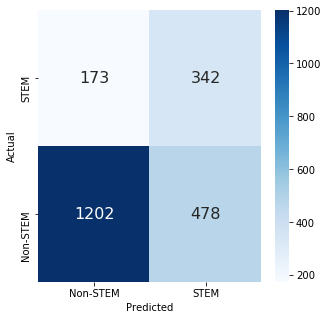

In [484]:
LR_confusion = metrics.confusion_matrix(y_test, test_pred)
df_cm = pd.DataFrame(LR_confusion,columns=['Non-STEM','STEM'],index=['Non-STEM','STEM'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(df_cm,cmap='Blues',annot=True,annot_kws={'size':16},fmt='g');
ax.set_ylim([0,2])

## Which did it get wrong?

In [66]:
comparison = pd.DataFrame(data = {'predicted': train_pred, 'actual': y_train})
errors = comparison[comparison['predicted'] != comparison['actual']]

fp = errors[errors['predicted'] == 1]
fn = errors[errors['predicted'] == 0]

In [67]:
error_df = comparison.merge(X_train, how = 'right', right_index = True, left_index = True)

In [68]:
error_df['wrong'] = np.where((error_df['predicted'] != error_df['actual']), 1, 0)

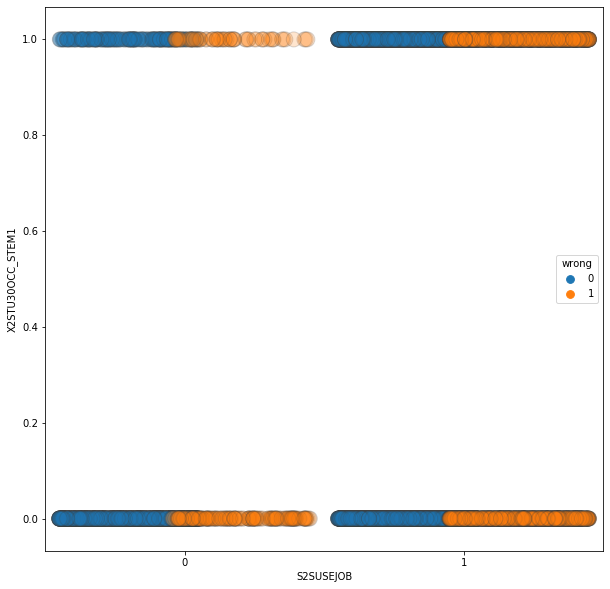

In [88]:
fig = plt.figure(figsize = (10,10))
sns.stripplot(error_df['S2SUSEJOB'], error_df['X2STU30OCC_STEM1'], hue = error_df['wrong'], linewidth = 1, alpha = 0.2, size = 15, jitter = 0.5, dodge = True)






## Threshold Testing

In [498]:
from sklearn.metrics import roc_curve, roc_auc_score


In [512]:
THRESHOLD = .5
lr_test_pred = np.where(lr_fsm.predict_proba(X_test[features])[:,1] > THRESHOLD, 1, 0)
lr_train_pred = np.where(lr_fsm.predict_proba(X_train[features])[:,1] > THRESHOLD, 1, 0)

In [513]:
#metric_dict = {}
metric_dict['0.6'] = {'train_accuracy': metrics.accuracy_score(y_train, lr_train_pred),
                                      'test_accuracy': metrics.accuracy_score(y_test, lr_test_pred),
                                      'train_precision':metrics.precision_score(y_train, lr_train_pred),
                                      'test_precision':metrics.precision_score(y_test, lr_test_pred),
                                      'train_recall':metrics.recall_score(y_train, lr_train_pred),
                                      'test_recall':metrics.recall_score(y_test, lr_test_pred),
                                      'train_f1':metrics.f1_score(y_train, lr_train_pred),
                                      'test_f1':metrics.f1_score(y_test, lr_test_pred)}

In [514]:
metric_dict

{'0.8': {'train_accuracy': 0.7923453696320766,
  'test_accuracy': 0.7886104783599088,
  'train_precision': 0.6636636636636637,
  'test_precision': 0.650887573964497,
  'train_recall': 0.21656050955414013,
  'test_recall': 0.21359223300970873,
  'train_f1': 0.3265607683782786,
  'test_f1': 0.3216374269005848},
 '0.7': {'train_accuracy': 0.790295022212097,
  'test_accuracy': 0.7977220956719818,
  'train_precision': 0.5694444444444444,
  'test_precision': 0.60790273556231,
  'train_recall': 0.4017638412542871,
  'test_recall': 0.3883495145631068,
  'train_f1': 0.47112898592358515,
  'test_f1': 0.47393364928909953},
 '0.5': {'train_accuracy': 0.7038387060029616,
  'test_accuracy': 0.7034168564920273,
  'train_precision': 0.41877361232199944,
  'test_precision': 0.4170731707317073,
  'train_recall': 0.7060264576188143,
  'test_recall': 0.6640776699029126,
  'train_f1': 0.5257205399489238,
  'test_f1': 0.5123595505617977},
 '0.4': {'train_accuracy': 0.6260394122337396,
  'test_accuracy': 0.6

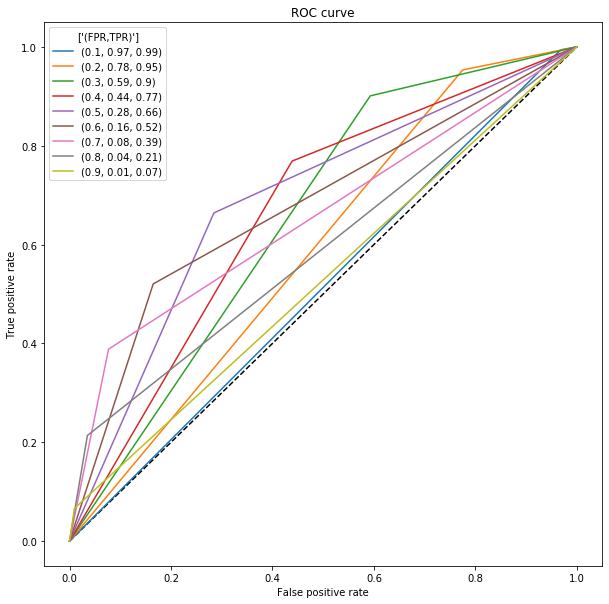

In [518]:
# differnt thresholds for predicting target
threshs = np.arange(0.1,1,0.1)

# going through each threshold to determine flase and true positive rate
y_test_roc = y_test
def roc_per_thresh(threshs):
    rocs = []
    for thresh in threshs:
        # predicting and getting false positive and false negative rates
        # as the threshold for predicting true is increased
        y_pred_roc = (lr_fsm.predict_proba(X_test[features]) > thresh).astype('int32')
        y_pred_roc = y_pred_roc.T[[1]][0]
        fpr, tpr, thresholds = roc_curve(y_test_roc, y_pred_roc)
        rocs.append([thresh,fpr,tpr])
    return rocs

roc_values = roc_per_thresh(threshs)

plt.figure(1,figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
for roc in roc_values:
    plt.plot(roc[1],roc[2],label=(round(roc[0],1),round(roc[1][1],2),round(roc[2][1],2)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(title=['(FPR,TPR)'])
plt.show()

In [694]:
y_test.shape

(2195,)

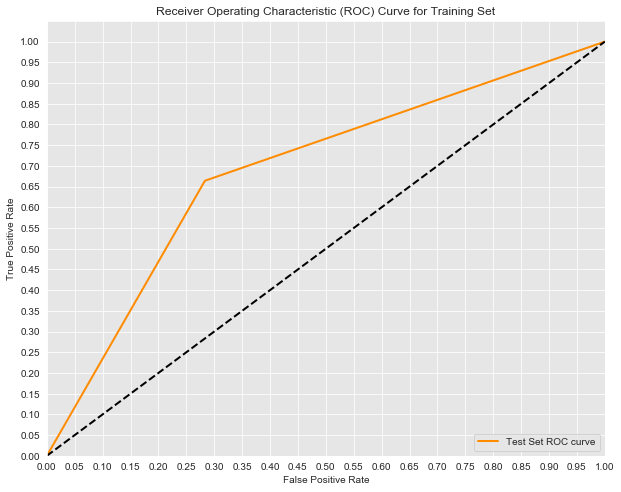

Test AUC: 0.6903721682847896


In [707]:
test_fpr, test_tpr, thresholds = roc_curve(y_test, gs_test_pred)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, gs_train_pred)
test_auc = metrics.roc_auc_score(y_test, gs_test_pred)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test Set ROC curve')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
plt.show()
print('Test AUC:', auc)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, test_pred[1])
plt.figure(1,figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(title=['(FPR,TPR)'])
plt.show()

In [520]:
metrics.roc_auc_score(y_test, test_pred)

0.6897769301895516

The area under the curve score (AUC) is 0.69. This shows that the model is better than random guessing (AUC score of 0.5). However, with more data and further analysis, there is room for improvement.

## Coefficients Ranked

In [ ]:
coef_model = dict(zip(list(features), list(abs(lr_gs.coef_[0]))))
viz_dict = sorted(coef_model.items(), key=lambda kv: kv[1])
viz_dict.reverse()

top_ten = viz_dict[:10]
coefs_df = pd.DataFrame(data = top_ten, columns = ['feature', 'coefficient_value'])

plt.figure(figsize = (10,10))
clrs = ['red' if x == 'female' else 'red' if x == 'black' else 'red' if x== 'misc_class' else 'skyblue' for x in coefs_df['feature']]
ax = sns.barplot(x ='coefficient_value', y = 'feature', data = coefs_df, palette = clrs, orient = 'horiz' )
plt.yticks(ticks = range(0,11), labels = ['Female', 'Engineering Class', 'Asian', 'Plans to Pursue STEM', 'Taking Computer Science Class', 'Participated in Science Summer Program', 'Black', 'Thinks STEM is Useful for Job', 'Taking Misc Science Class', 'Sees Self As Science Person'])
plt.margins(0.1, 0.02)
ax.set_ylabel('Feature')
ax.set_xlabel('Coefficient Value (Absolute Value)')

;

In [682]:
# create a dataframe of the correlation values.
df_corr=X_train[features].corr().abs().stack().reset_index().sort_values(0, ascending=False)

# list and zip the variable name columns in the new column named "pairs"
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

# set index to pairs
df_corr.set_index(['pairs'], inplace = True)

#drop the level columns
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as 'cc'
df_corr.columns = ['cc']

# drop duplicates.
df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.70) & (df_corr.cc <1)]

,cc
pairs,
"(S2STCHINTRST, S2STCHEASY)",0.702425
